In [1]:
"""" 
aggregate RTOFS data (which is used to force RTOFS) under smb://mule/disk3/projects/tc2022/
named like:
/mule/tc2022/RTOFS/study_area
    /mule/tc2022/tc2023/RTOFS/study_area
    /mule/tc2022/tc2024/RTOFS/study_area
    /mule/tc2022/RTOFS/study_area
    ocean u, v velocities are in the daily files with names like surface.now.20221102.nc
    "now" signifies analysis data in this case, as opposed to forecasted data.

to produce hourly momentum flux and surface ocean current data that offers
a chance to evaluate wind work on currents at the GFS and RTOFS horizontal scales 
(~ 12km for GFS/ 0.117 deg)(~8 km for RTFS/ 0.08 deg)
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys

In [2]:
storm = 'Lee'
year = '2023'
data_type = 'surface.now.'
path = '/Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/'
filenames_all = np.sort( os.listdir(path) )
filenames = np.array([])
for file in filenames_all:
    if ('.nc' in file) & (file[:12] == data_type):
        filenames = np.append(filenames, file)
print(len(filenames), filenames)

datelim = [datetime.datetime(int(year),9,5), datetime.datetime(int(year),9,22)]
nfiles = (datelim[1]-datelim[0]).days+1
print(nfiles)
file_dates = [(datelim[0]+datetime.timedelta(days=i)).strftime('%Y%m%d') for i in range(nfiles)]
print(file_dates)

120 ['surface.now.20230720.nc' 'surface.now.20230721.nc'
 'surface.now.20230722.nc' 'surface.now.20230723.nc'
 'surface.now.20230724.nc' 'surface.now.20230725.nc'
 'surface.now.20230726.nc' 'surface.now.20230727.nc'
 'surface.now.20230728.nc' 'surface.now.20230729.nc'
 'surface.now.20230730.nc' 'surface.now.20230731.nc'
 'surface.now.20230801.nc' 'surface.now.20230802.nc'
 'surface.now.20230803.nc' 'surface.now.20230804.nc'
 'surface.now.20230805.nc' 'surface.now.20230806.nc'
 'surface.now.20230807.nc' 'surface.now.20230808.nc'
 'surface.now.20230809.nc' 'surface.now.20230810.nc'
 'surface.now.20230811.nc' 'surface.now.20230812.nc'
 'surface.now.20230813.nc' 'surface.now.20230814.nc'
 'surface.now.20230815.nc' 'surface.now.20230816.nc'
 'surface.now.20230817.nc' 'surface.now.20230818.nc'
 'surface.now.20230819.nc' 'surface.now.20230820.nc'
 'surface.now.20230822.nc' 'surface.now.20230823.nc'
 'surface.now.20230824.nc' 'surface.now.20230825.nc'
 'surface.now.20230826.nc' 'surface.now.20

In [3]:
''' Read one file a time to aggregate selected variables of interest'''
str_vars = ['MT','LAYER','LONGITUDE','LATITUDE','U_VELOCITY','V_VELOCITY','MIXED_LAYER_THICKNESS']
vars_nostack = ['LAYER','LONGITUDE','LATITUDE']
''' Cread Dictionary'''
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']#,'_FillValue']
ds = nc.Dataset( path+data_type+file_dates[0]+'.nc')
nz = len(ds.variables['LAYER'])
varnms = list( ds.variables.keys() )
print(varnms)
''' add empty items to the dictionary '''
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in str_vars:
        print(vkey)
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        attrnms = ds.variables[vkey].ncattrs()
        # print(attrnms)
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            if attr[a] in attrnms:
                print(attr[a])
                str_eval = "ds.variables['" + vkey + "']." + attr[a]
                vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
                print(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')

['MT', 'MT_bnds', 'DATE', 'X2300_3200', 'Y1600_2150', 'LATITUDE', 'LONGITUDE', 'LAYER', 'U_VELOCITY', 'V_VELOCITY', 'SST', 'SSS', 'SSH', 'SURFACE_BOUNDARY_LAYER_THICKNESS', 'MIXED_LAYER_THICKNESS']
MT
long_name
ds.variables['MT'].long_name
units
ds.variables['MT'].units
LATITUDE
long_name
ds.variables['LATITUDE'].long_name
units
ds.variables['LATITUDE'].units
LONGITUDE
long_name
ds.variables['LONGITUDE'].long_name
units
ds.variables['LONGITUDE'].units
LAYER
units
ds.variables['LAYER'].units
U_VELOCITY
long_name
ds.variables['U_VELOCITY'].long_name
units
ds.variables['U_VELOCITY'].units
V_VELOCITY
long_name
ds.variables['V_VELOCITY'].long_name
units
ds.variables['V_VELOCITY'].units
MIXED_LAYER_THICKNESS
long_name
ds.variables['MIXED_LAYER_THICKNESS'].long_name
units
ds.variables['MIXED_LAYER_THICKNESS'].units
15 variables in nc file & 7 variables are selected to append


In [ ]:
### go through each (mostly daily) nc file & append the selected variables 
cnt = 0
for f in range( len(file_dates) ):
    try: # block raising an exception
        ds = nc.Dataset( path+data_type+file_dates[f]+'.nc')
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey in str_vars) & (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = ds.variables[vkey][:]
                ### append in time dimension only
                if cnt == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                if cnt == 0: ### for variables that do not need to append in time
                    for var_nostack in vars_nostack:
                        vars_dic[var_nostack] = ds.variables[var_nostack][:]
        ds.close()
        print('Done',file_dates[f])
        cnt = cnt + 1
    except: # doing nothing on exception
        print(file_dates[f],'data file raise an exception')
        pass
print('There are ',vars_dic['MT'].shape,'hours total.')

Done 20230905
Done 20230906
Done 20230907
Done 20230908
Done 20230909
Done 20230910
Done 20230911
Done 20230912
Done 20230913
Done 20230914
Done 20230915
Done 20230916
Done 20230917
Done 20230918
Done 20230919
Done 20230920
Done 20230921
Done 20230922
There are  (432,) hours total.


(432, 1, 551, 901)
20230922
[20230921.         20230921.04166667 20230921.08333333 20230921.125
 20230921.16666667 20230921.20833333 20230921.25       20230921.29166667
 20230921.33333333 20230921.375      20230921.41666667 20230921.45833333
 20230921.5        20230921.54166667 20230921.58333333 20230921.625
 20230921.66666667 20230921.70833333 20230921.75       20230921.79166667
 20230921.83333333 20230921.875      20230921.91666667 20230921.95833333]


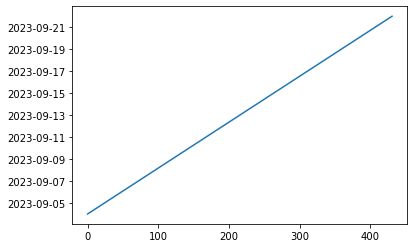

In [5]:
dtime = np.array([datetime.datetime(1900,12,31)+datetime.timedelta(days=i) for i in vars_dic['MT']])
time_out = np.array( [(i-datetime.datetime(int(year),1,1)).total_seconds() for i in dtime] )
plt.plot(dtime)
print(vars_dic['V_VELOCITY'].shape)
### Also check DATE in the nc file!
print(file_dates[f])
ds = nc.Dataset( path+data_type+file_dates[f]+'.nc')
test = ds.variables['DATE'][:]
print(test)

In [ ]:
''' Write merged RTOFS data to netcdf file'''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'RTOFS.merge.'+data_type+file_dates[0]+'-'+file_dates[-1]+'.nc'
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
depth_dim = ncfile.createDimension('depth', len(vars_dic['LAYER'])) # depth axis
lon_dim = ncfile.createDimension('longitude', vars_dic['U_VELOCITY'].shape[3])
lat_dim = ncfile.createDimension('latitude', vars_dic['U_VELOCITY'].shape[2])
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for RTOFS '+data_type+' data between '+file_dates[0]+' and '+file_dates[-1]
print(ncfile.title)
ncfile.subtitle="Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
depth_out = vars_dic['LAYER']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 432)
('depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'depth', size = 1)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 901)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 551)
Merged files for RTOFS surface.now. data between 20230905 and 20230922
Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(432), depth(1), longitude(901), lati

In [7]:
### Creating variables
depth = ncfile.createVariable('depth', np.float64, ('depth',))
depth.units = 'meter'
depth.long_name = 'depth'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
vars_names = ['LONGITUDE','LATITUDE','U_VELOCITY','V_VELOCITY','MIXED_LAYER_THICKNESS']
### 2: (Y, X) 3: (time, Y, X) 4: (time, depth, Y, X)
dim_cat = [2,2,4,4,3]
for i, var_name in enumerate(vars_names):
    print(var_name)
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 2:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + "', np.float64, ('" + 'latitude' + "','"+ 'longitude' +"'))"
    elif dim_cat[i] == 3:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    elif dim_cat[i] == 4:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'depth' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    exec(str_exec)
    print(i,str_exec)
    ### add attributes
attr_keys = vars_dic_attr.keys()
str_no = ['MT','LAYER']
for attr_key in attr_keys:
    i_ = attr_key.find('-')
    if attr_key[:i_] not in str_no:
        str_exec = attr_key.replace('-','.') + " = '"+ str(vars_dic_attr[attr_key]) + "'"
        exec(str_exec)

LONGITUDE
0 LONGITUDE= ncfile.createVariable('LONGITUDE', np.float64, ('latitude','longitude'))
LATITUDE
1 LATITUDE= ncfile.createVariable('LATITUDE', np.float64, ('latitude','longitude'))
U_VELOCITY
2 U_VELOCITY= ncfile.createVariable('U_VELOCITY', np.float64, ('time','depth','latitude','longitude'))
V_VELOCITY
3 V_VELOCITY= ncfile.createVariable('V_VELOCITY', np.float64, ('time','depth','latitude','longitude'))
MIXED_LAYER_THICKNESS
4 MIXED_LAYER_THICKNESS= ncfile.createVariable('MIXED_LAYER_THICKNESS', np.float64, ('time','latitude','longitude'))


In [8]:
### writing data
# Note: the ":" is necessary in these "write" statements
depth[:] = vars_dic['LAYER']
time[:] = time_out
for i, var_name in enumerate(vars_names):
    if dim_cat[i] == 2:
        str_exec = var_name + "[:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 3:
        str_exec = var_name + "[:,:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 4:
        str_exec = var_name + "[:,:,:,:]= vars_dic['" + var_name + "']"
    exec(str_exec)
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(432), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 LONGITUDE(latitude, longitude), float64 LATITUDE(latitude, longitude), float64 U_VELOCITY(time, depth, latitude, longitude), float64 V_VELOCITY(time, depth, latitude, longitude), float64 MIXED_LAYER_THICKNESS(time, latitude, longitude)
    groups: 
Dataset is closed!


In [63]:
print(vars_dic['MIXED_LAYER_THICKNESS'].shape)

(432, 551, 901)
